# Introducción

En el presente documento se realizan un ajustes de regresión lineal a partir de datos de cierta ciudad obtenidos en un estudio  que considera que el consumo de agua [m$^2$/mes] está relacionado con el consumo de energía eléctrica [kW/h]. 

Durante el proceso de análisis se descubre empíricamente que los datos originales no satisfacen del todo los supuestos del modelo de regresión lineal y se realiza una transformación para corregir dicha desviación. 

El enfoque de este reporte se centra en la comparación de los ajustes lineales obtenidos para los datos originales y para los datos transformados, así como en la realización de inferencias a partir del último ajuste. 

# a) Grafique los datos y comente.

Primero, vamos a mencionar dos aspectos importantes de los datos con los que trabajaremos: los datos proporcionados constan de 50 pares de observaciones y son variables continuas.



In [1]:
# Importación de librerías y configuraciones generales.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

pd.options.display.precision = 2 # Para 2 decimales.

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Options
params = {'font.family':'STIXGeneral',
          'text.usetex' : True,
          'font.size' : 11
          }

plt.rcParams.update(params) 

In [2]:
def get_x_bar(df, x):
    return df[x].mean()

def get_y_bar(df, y):
    return df[y].mean()

def get_S_xx(df, x):
    return ((df[x] - get_x_bar(df, x))**2).sum()

def fit(df, x, y):
    """
    df: DataFrame con la columna del regresor y la columna de la variable respuesta.
    x:  str con el nombre de la columna del regresor.
    y:  str con el nombre de la columna de la variable respuesta.
    """
    x_bar = get_x_bar(df, x) # Promedio de observaciones del regresor.
    y_bar = get_y_bar(df, y) # Promedio de observaciones de la variable respuesta.

    S_xy = (df[y]*(df[x] - x_bar)).sum()
    S_xx = get_S_xx(df, x)

    beta_1 = S_xy/S_xx # Estimador de mínimos cuadrados de la pendiente del modelo de regresión lineal.
    beta_0 = y_bar - beta_1*x_bar  # Estimador de mínimos cuadrados del intercept del modelo de regresión lineal.

    y_fit = beta_0 + beta_1*df[x] # Ajuste de regresión lineal
    y_fit.rename("y_fit", inplace = True)
    
    return y_fit, beta_0, beta_1

def get_SS_res(df, y, y_fitted):
    """
    df:       DataFrame con la columna de la variable respuesta y la columna de la respuesta ajustada.
    y:        str con el nombre de la columna de la variable respuesta.
    y_fitted: str con el nombre de la columna de la respuesta ajustada.
    """
    return sum((df[y] - df[y_fitted])**2)

def get_MS_res(df, y, y_fit):
    n = len(df.index) # Número de observaciones
    return (1/(n-2))*get_SS_res(df, y, y_fit)

def test_beta_0(df, x, y, y_fit, beta_0, beta_0_test = 0, alpha = 0.05):
    n = len(df.index) # Número de observaciones
    
    x_bar = get_x_bar(df, x)
    S_xx = get_S_xx(df, x)
    MS_res = get_MS_res(df, y, y_fit)
    
    t_0 = (beta_0 - beta_0_test)/(np.sqrt(MS_res*(1/n + x_bar**2/S_xx)))
    nu = n - 2
    test_statistic = stats.t.ppf(alpha/2, nu)
    p_value = stats.t.cdf(-abs(t_0), nu) + 1-stats.t.cdf(abs(t_0), nu)
    
    if p_value < alpha:
        print("Significancia del ajuste: \n\t Como el valor p = " + "{:.2e}".format(p_value) + f" < {alpha} = 𝛼, se rechaza la hipótesis nula H_0: 𝛽_0 = {beta_0_test} \n")
    else:
        print("Significancia del ajuste: \n\t Como el valor p = " + "{:.2e}".format(p_value) + f" > {alpha} = 𝛼, NO se rechaza la hipótesis nula H_0: 𝛽_0 = {beta_0_test} \n")
    return t_0, test_statistic, p_value

def test_beta_1(df, x, y, y_fitted, beta_1, beta_1_test = 0, alpha = 0.05):
    n = len(df.index) # Número de observaciones
    
    S_xx = get_S_xx(df, x)
    MS_res = get_MS_res(df, y, y_fitted)
    
    t_0 = (beta_1 - beta_1_test)/(np.sqrt(MS_res/S_xx))
    nu = n - 2
    test_statistic = stats.t.ppf(alpha/2, nu)
    p_value = stats.t.cdf(-abs(t_0), nu) + 1-stats.t.cdf(abs(t_0), nu)
    
    if p_value < alpha:
        print("Significancia del ajuste: \n\t Como el valor p = " + "{:.2e}".format(p_value) + f" > {alpha} = 𝛼, se rechaza la hipótesis nula H_0: 𝛽_1 = {beta_1_test} \n")
    else:
        print("Significancia del ajuste: \n\t Como el valor p = " + "{:.2e}".format(p_value) + f" > {alpha} = 𝛼, NO se rechaza la hipótesis nula H_0: 𝛽_1 = {beta_1_test} \n")
    return t_0, test_statistic, p_value

def get_SS_r(df, y, y_fit):
    return sum((df[y_fit] - get_y_bar(df, y))**2)

# No sé por qué la estadística de prueba de F(alpha, 1, n-2) no es la que debería ser.

def test_analysis_of_variance(df, y, y_fit, beta_1_test = 0, alpha = 0.05):
    n = len(df.index) # Número de observaciones
    SS_res = get_SS_res(df, y, y_fit)
    SS_r = get_SS_r(df, y, y_fit)
    
    nu = n - 2
    F_0 = ((SS_r/1)/(SS_res/nu))
    test_statistic = stats.f.ppf(alpha, 1, nu)
    p_value = stats.f.cdf(-abs(F_0), 1, nu) + 1-stats.f.cdf(abs(F_0), 1, nu)
    
    if p_value < alpha:
        print("Análisis de varianza: \n\t Como el valor p = " + "{:.2e}".format(p_value) + f" > {alpha} = 𝛼, se rechaza la hipótesis nula H_0: 𝛽_1 = {beta_1_test} \n")
    else:
        print("Análisis de varianza: \n\t Como el valor p = " + "{:.2e}".format(p_value) + f" > {alpha} = 𝛼, NO se rechaza la hipótesis nula H_0: 𝛽_1 = {beta_1_test} \n")
    
    return F_0, test_statistic, p_value

def get_SS_t(df, y):
    return sum((df[y] - get_y_bar(df, y))**2)
    
def get_R_2(df, y, y_fit):
    R_2 = np.round(get_SS_r(df, y, y_fit)/get_SS_t(df, y), 4)
    print(f"El valor de R^2 para este ajuste es {R_2}")
    return R_2


def get_lambda(df, x, y, l_lb = -1, l_ub = 1,  num_l = 9):
    lambdas = np.linspace(l_lb, l_ub, num_l)
    SS_trans_res = []
    for l in lambdas:
        y_trans = box_cox_transformation(df, y, l)
        trans_df = pd.concat([df, y_trans], axis = 1)
        trans_df["y_fit"], _, _ = fit(trans_df, x, "y_trans")
        SS_trans_res.append(get_SS_res(trans_df, "y_trans", "y_fit"))

    min_index = SS_trans_res.index(min(SS_trans_res))
    l = lambdas[min_index]
    classification = [" " for i in range(0,len(lambdas))]
    classification[min_index] = "Óptimo"

    dictionary = {"$\lambda$": lambdas, "$SC_{{Res}}(\lambda)$": SS_trans_res, "Clasificación": classification}
    lambda_df = pd.DataFrame.from_dict(dictionary)
    return lambda_df

def box_cox_transformation(df, y, l):
    n = len(df.index) # Número de observaciones
    y_dot = (df[y].prod())**(1/n) # Promedio geométrico de las observaciones de la variable respuesta
    if l == 0:
        y_trans = y_dot*np.log(df[y])
    else:
        y_trans = (1/(l*y_dot**(l-1)))*(df[y]**l - 1)
    y_trans.rename("y_trans", inplace = True)
    return y_trans

def box_cox_transformation_single_obs(df, y, l, y_0):
    n = len(df.index) # Número de observaciones
    y_dot = float((df[y].prod())**(1/n)) # Promedio geométrico de las observaciones de la variable respuesta
    if l == 0:
        y = y_dot*np.log(y_0)
    else:
        y = (1/(l*y_dot**(l-1)))*(y_0**l - 1)
    return y

def inv_box_cox_transformation_single_obs(df, y, l, y_lambda_0):
    n = len(df.index) # Número de observaciones
    y_dot = float((df[y].prod())**(1/n)) # Promedio geométrico de las observaciones de la variable respuesta
    if l == 0:
        y = np.exp(y_lambda_0/y_dot)
    else:
        y = (l*y_lambda_0*y_dot**(l-1)+1)**(1/l)
    return y

def prediction_CI(df, x, y, y_fit, x_0, beta_0, beta_1, alpha = 0.05, mean = True):
    y_0 = beta_0 + beta_1*x_0
    
    n = len(df.index) # Número de observaciones
    nu = n - 2
    test_statistic = stats.t.ppf(alpha/2, nu)
    
    x_bar = get_x_bar(df, x)
    S_xx = get_S_xx(df, x)
    MS_res = get_MS_res(df, y, y_fit)
    
    if mean: 
        CI_lb = y_0 - test_statistic*np.sqrt(MS_res*(1/n + (x_0 - x_bar)**2/S_xx))
        CI_ub = y_0 + test_statistic*np.sqrt(MS_res*(1/n + (x_0 - x_bar)**2/S_xx))
    else:
        CI_lb = y_0 - test_statistic*np.sqrt(MS_res*(1 + 1/n + (x_0 - x_bar)**2/S_xx))
        CI_ub = y_0 + test_statistic*np.sqrt(MS_res*(1 + 1/n + (x_0 - x_bar)**2/S_xx))
        
    CI_lb, CI_ub = min(CI_lb, CI_ub), max(CI_lb, CI_ub)
    
    return CI_lb, CI_ub

In [3]:
from statsmodels.api import ProbPlot, qqline

colors = {
    'dots':  '#2b7bba',
    'dots2': '#89bedc',
    'model': '#e13342'
}

def palette_hex(palette_name):
    palette = sns.color_palette(palette_name)
    sns.palplot(palette)
    return palette.as_hex()

def fit_data(df):
    import statsmodels.formula.api as sm
    X = df['electricidad'].values.reshape(-1,1)
    y = df['agua'].values.reshape(-1,1) 
    formula_str = df.columns[-1]+' ~ '+'+'.join(df.columns[:-1])
    model=sm.ols(formula=formula_str, data=df)
    fitted = model.fit()

    b0 = fitted.summary2().tables[1]['Coef.']['Intercept']
    b1 = fitted.summary2().tables[1]['Coef.']['electricidad']

    residuals = fitted.resid
    y_approx = fitted.fittedvalues
    normal_resid = fitted.resid_pearson

    return fitted, b0, b1, y_approx, residuals, normal_resid

def format_plot(ax, x_label, y_label, caption = None):
    AXIS_SIZE = 12
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if caption:
        x_label = x_label + '\n\n' + caption

    ax.set_xlabel(x_label,fontsize=AXIS_SIZE)
    ax.set_ylabel(y_label, fontsize=AXIS_SIZE)
    
def model_plot(ax, y, X, b0, b1):
    y_approx = b0 + b1*X
    label = 'y ajustada\ny = {:.2f}x + {:.2f}'.format(b1, b0)
    ax.plot(X, y_approx, label = label, color = colors['model'])
    ax.scatter(X,y, alpha = 0.6, color = colors['dots'], label = 'y observada')

def scatter_plot(ax, X, y):
    ax.scatter(X,y, color = colors['dots'])
    
def residual_plot(ax, residuals, y_approx):
    xmin=min(y_approx)
    xmax = max(y_approx)
    ax.hlines(y=0, xmin=xmin*0.9, xmax=xmax*1.1, color='black',linestyle='--',lw=1, alpha = 0.6)
    ax.scatter(y_approx, residuals, color = colors['dots'])
    
def qq_plot(ax, residuals):
    pp = ProbPlot(residuals, fit=True)
    qq = pp.qqplot(alpha=0.7, markeredgecolor = colors['dots'], markerfacecolor = colors['dots'], ax = ax)
    qqline(ax, line='45', color='black',linestyle='--',lw=1, alpha = 0.6)
    
def histogram_plot(ax, y_approx):
    ax.hist(y_approx, bins=20, color = colors['dots'], edgecolor = 'k')

def plot(params, num = 1, x_labels = ['x'], y_labels = ['y'], captions = [''], types = ['scatter']):
    plots = {
        'scatter': scatter_plot,
        'residual': residual_plot,
        'modelo': model_plot,
        'qqplot': qq_plot,
        'histogram': histogram_plot
    }
    
    fig_num = num
    n_plots = len(types)
    fig, axes = plt.subplots(1, n_plots, figsize = (6*n_plots, 4))
    if n_plots == 1: axes = [axes]
        
    for ax, type_, param, x_label, y_label, caption in zip(axes, types, params, x_labels, y_labels, captions):
        plots[type_](ax = ax, **param)
        caption = 'Figura {}. {}'.format(fig_num, caption)
        format_plot(ax,
            x_label = x_label,
            y_label = y_label,
            caption = caption
        )
        fig_num += 1
        
    if 'modelo' in types:
        plt.legend()

    plt.show()

In [4]:
# Función para graficar scatter plot con opción para incluir o no el ajuste de regresión lineal.
def scatter_fit_plot(df, x, y, caption, color = "blue", trans = False, **kwargs):
    plt.figure()
    plt.figure(figsize=(10,10))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(x + "\n\n" + caption,fontsize=20)
    plt.ylabel(y, fontsize=20)
    plt.title(y + " vs. " + x, fontsize=20)
    
    if trans: 
        label = "Valores transformados"
    else:
        label = "Valores observados"
    scatter = plt.scatter(df[x], df[y], 
                          c = color, 
                          s = 100, 
                          alpha = 0.6, 
                          label = label)
    
    if "y_fit" in kwargs:
        y_fit = kwargs.get("y_fit")
        
        if "beta_0" in kwargs and "beta_1" in kwargs:
            beta_0 = kwargs.get("beta_0")
            beta_1 = kwargs.get("beta_1")
            
            if beta_1 > 0:
                sign = "+"
            else:
                sign = "-"
            line = plt.plot(df[x], df[y_fit], 
                        c = "#75cd01",
                        label = f"Valores ajustados: \n y = {np.round(beta_0,2)} {sign} {abs(np.round(beta_1,2))}x")
    plt.legend(prop={'size': 15})
    plt.show()

In [5]:
# Leer los datos del archivo `control2.dat` cuyas columnas están separadas por múltiples espacios.
df = pd.read_csv('control2.dat', sep='\s+')

# A lo largo del doc se alterna entre las etiquetas para tener resultados presentables y código legible.
pretty_columns = ["Consumo eléctrico [kW/h]", "Consumo de agua [m$^2$/mes]"] # Columnas para display, plot, etc.
working_columns = ["x", "y"] # Columnas para código y cálculos.

df.columns = ["Observación"] + pretty_columns

# Etiquetar las observaciones con las numeración provista
df = df.set_index('Observación')

In [6]:
 display(df.head())

,Consumo eléctrico [kW/h],Consumo de agua [m$^2$/mes]
Observación,,
1,0.16,3.76
2,0.44,4.05
3,0.63,4.26
4,0.76,4.37
5,1.04,4.51



A continuación se presenta una gráfica que presenta los pares de las mediciones `Consumo eléctrico` y `Consumo de agua`, medidos en *kw/hr* y *m$^2$/mes* respectivamente, de cada observación.

KeyError: 'Consumo de agua [m$^2$/mes]'

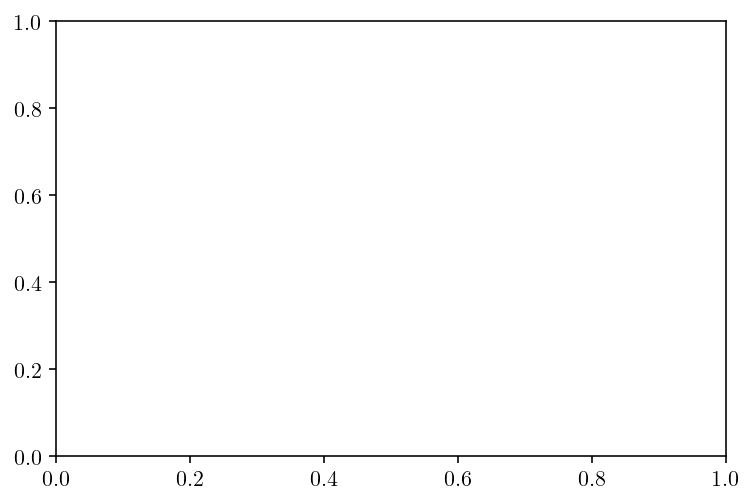

In [28]:
# INSERTAR PLOT QUE MÓNICA COMENTÓ EN LA LLAMADA, ESE ES Figura 1.
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(df['Consumo de agua [m$^2$/mes]'], 'o', color=colors['dots'], label="Consumo de agua")
ax.plot(df['Consumo eléctrico [kW/h]'], 'o', color=colors['dots2'], label="Consumo de electricidad")

format_plot(ax,
            x_label = 'Número de observación',
            y_label = 'Consumo de agua y electricidad',
            caption = 'Figura 1. Consumo de agua medida en m$^2$/mes y consumo de electricidad medido en kw/hr'
           )
leg = ax.legend()
plt.show()

Como podemos observar, ambos tipos de consumo tienen una tendencia creciente. Sin embargo, el `consumo eléctrico` presenta cambios pequeños en cada observación, además, da la impresión de que el cambio es constante.

Por otro lado, a pesar de que el `consumo de agua` empieza con cambios pequeños y crecientes, después de la quinta observación podemos notar que se presentan cambios más grandes entre cada observación y no todos los consumos son mayores que los anteriores. En resumen, los valores del `consumo de agua` tienen más variabilidad que los del `consumo eléctrico`.

Ahora, vamos a graficar los datos tomando en cuenta al `Consumo eléctrico` como la variable independiente y al `Consumo de agua` como la variable dependiente.

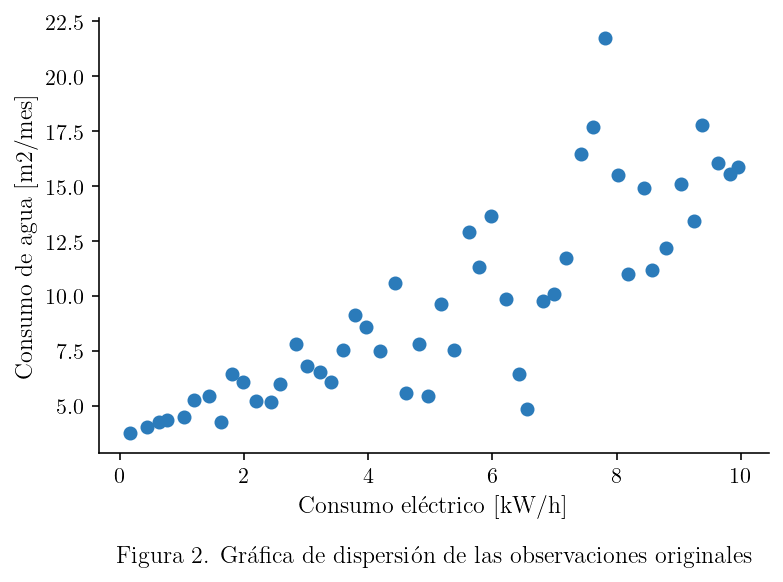

In [8]:
params = {
    'X': df['Consumo eléctrico [kW/h]'],
    'y': df['Consumo de agua [m$^2$/mes]']
}
plot(
    params = [params],
    num = 2,
    x_labels = ['Consumo eléctrico [kW/h]'],
    y_labels = ['Consumo de agua [m2/mes]'],
    captions = ['Gráfica de dispersión de las observaciones originales'],
    types = ['scatter']
)

# b) Ajuste un modelo de regresión lineal simple sobre los datos sin transformar.

Ahora, queremos encontrar un modelo lineal que nos diga el `Consumo de agua` dado que tenemos un `Consumo eléctrico` fijo.

El modelo que obtenemos es:

y=1.3X+2.88

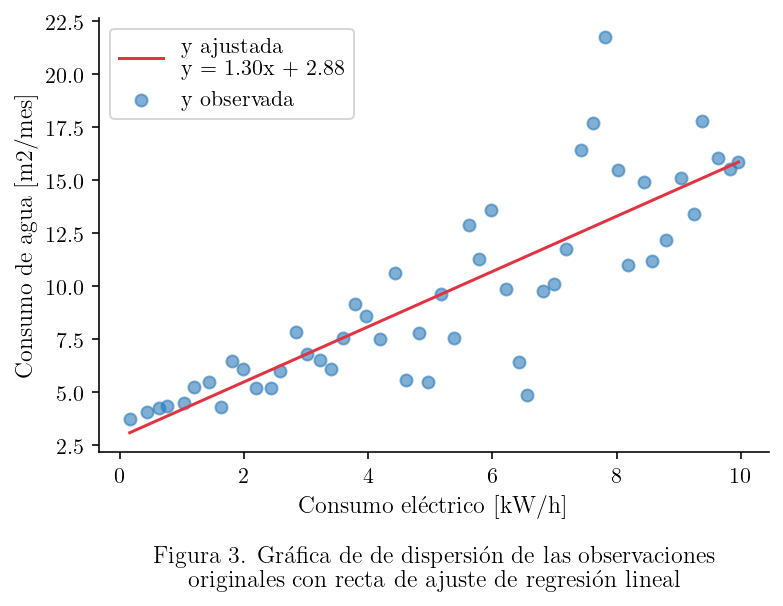

In [9]:
df.columns = working_columns

df["y_fit"], beta_0, beta_1 = fit(df, "x", "y")
pretty_columns = ["Consumo eléctrico [kW/h]", 
                  "Consumo de agua [m$^2$/mes]",
                  "Ajuste lineal (respuesta original)"]
df.columns = pretty_columns
params = {
    'X': df['Consumo eléctrico [kW/h]'],
    'y': df['Consumo de agua [m$^2$/mes]'],
    'b0': beta_0,
    'b1': beta_1
}
plot(
    params = [params],
    num = 3,
    x_labels = ['Consumo eléctrico [kW/h]'],
    y_labels = ['Consumo de agua [m2/mes]'],
    captions = ['Gráfica de de dispersión de las observaciones \n originales con recta de ajuste de regresión lineal'],
    types = ['modelo']
)

In [10]:
working_columns = ["x", "y", "y_fit"]
df.columns = working_columns

_, _, p_value_beta_0 = test_beta_0(df, "x", "y", "y_fit", beta_0)
_, _, p_value_beta_1 = test_beta_1(df, "x", "y", "y_fit", beta_1)
#_, _, p_value_anova = test_analysis_of_variance(df, "y", "y_fit")
R_2 = get_R_2(df, "y", "y_fit")

Significancia del ajuste: 
	 Como el valor p = 1.68e-04 < 0.05 = 𝛼, se rechaza la hipótesis nula H_0: 𝛽_0 = 0 

Significancia del ajuste: 
	 Como el valor p = 1.88e-14 > 0.05 = 𝛼, se rechaza la hipótesis nula H_0: 𝛽_1 = 0 

El valor de R^2 para este ajuste es 0.7087


# c) Verifique su modelo via análisis de residuales. Comente.

Con el modelo que obtuvimos, podemos calcular el consumo de agua esperado (respuesta ajustada) y el error residual entre el modelo y los datos observados (error residual). Ahora, vamos a graficar los `errores residuales` vs la `respuesta ajustada`.

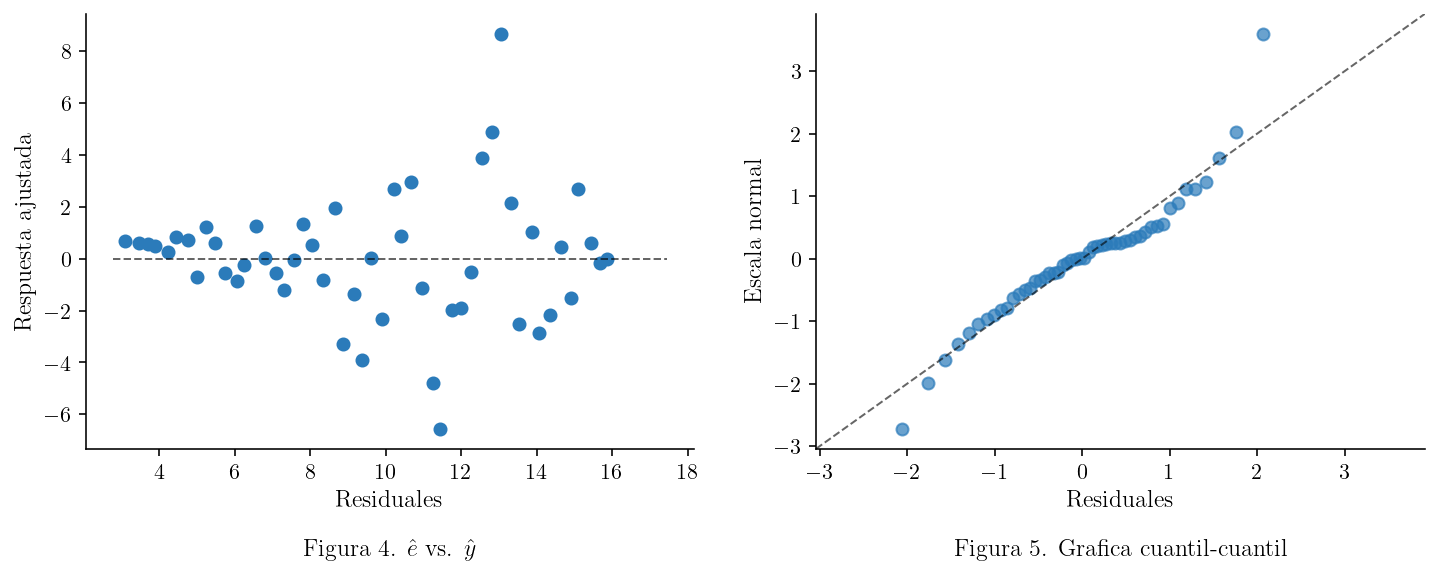

In [11]:
residuales_df = pd.DataFrame(index=df.index, columns=["Respuesta original ajustada", "Residuales"])
residuales_df["Respuesta original ajustada"] = df["y_fit"]
residuales_df["Residuales"] = df["y"] - df["y_fit"]
params_res = {
    'residuals': residuales_df["Residuales"],
    'y_approx': residuales_df["Respuesta original ajustada"],
}

df_qq = df.copy()
df_qq.columns = ['electricidad', 'agua', 'y_fit']
df_qq = df_qq.drop(columns = ['y_fit'])
fitted, b0, b1, y_approx, residuals, normal_resid = fit_data(df_qq)
params_qq = {
    'residuals': normal_resid
}

plot(
    params = [params_res, params_qq],
    num = 4,
    x_labels = ['Residuales', 'Residuales'],
    y_labels = ['Respuesta ajustada', 'Escala normal'],
    captions = ['$\hat{e}$ vs. $\hat{y}$', 'Grafica cuantil-cuantil'],
    types = ['residual', 'qqplot']
)

La figura 5 nos deja ver que nuestros residuales no cumplen con el supuesto de normalidad y además en la figura 4 podemos ver que los residuales tienen un comportamiento no aleatorio por lo que este modelo no tiene un muy buen ajuste.

In [12]:
beta_0_original = beta_0
beta_1_original = beta_1

# d) Aplique la transformación de Box-Cox y construya un intervalo del 90% de confianza para $\lambda$. ¿Que valor de $\lambda$ elegiría para la trasformación? Comente.

Aplicar la transformación de Box-Cox a la variable respuesta puede mejorar el ajuste y puede corregir violaciones de los supuestos del modelo de regresión lineal simple. Un requisito para poder aplicar esta transformación es que la variable respuesta conste únicamente de entradas positivas. Para validar que los datos disponibles satisfagan este requisito a continuación se cuenta la cantidad de entradas no positivas de la variable respuesta.

In [13]:
working_columns = ["x", "y", "y_fit"]
df.columns = working_columns
count = len(df[df["y"] <= 0].index)
print(f"El número de entradas no positivas de la variable respuesta es: {count}")

El número de entradas no positivas de la variable respuesta es: 0


Para poder aplicar directamente la fórmula de $y^{(\lambda)}$ de la transformación de Box-Cox, primero es necesario encontrar un valor óptimo $\hat{\lambda}$. El criterio de optimalidad para el parámetro $\hat{\lambda}$ es que la suma de los cuadrados de los residuales $SC_{\text{Res}}(\lambda)$ resultante de ajustar el modelo a partir de la respuesta sea mínima; es decir, $\lambda$ está dado por

$$
\begin{aligned}
\hat{\lambda} &= \arg \min_{\lambda \in \mathbb{R}} SC_{\text{Res}}(\lambda)  \\
&= \arg \min_{\lambda \in \mathbb{R}} \sum_{i = 1}^n \left(y_i - y_i^{(\lambda)}\right)^2
\end{aligned}
$$

En la práctica, se elige un rango de valores de prueba del parámetro $\lambda$, se aplica la transfarmación de Box-Cox para cada uno de los valores dentro del rango, se ajusta el modelo para cada una de las transformaciones de la respuesta original y se utiliza aquél valor de $\lambda$ con el que se obtenga la suma de cuadrados de los residuales $SC_{\text{Res}}(\lambda)$ mínima.

El resultado de aplicar este procedimiento con $\lambda \in [-1, 1]$ se muestra a continuación.

In [14]:
lambda_df = get_lambda(df, "x", "y")
pd.options.display.width = 500000
styles = [dict(selector="caption", 
    props=[("text-align", "center"),
    ("font-size", "120%"),
    ("color", 'black')])]
lambda_df = lambda_df.style.set_caption('Tabla X: Estimación de $\hat{\lambda}$ para la trasformación de Box-Cox').set_table_styles(styles)
#display(lambda_df)


from pandas import option_context

with option_context('display.width', 60000):
    display(lambda_df)

lambda_df.columns = ["$\lambda$", "$SC_{\text{Res}}(\lambda)$", "Clasificación"]

,$\lambda$,$SC_{{Res}}(\lambda)$,Clasificación
0,-1.00,239.33,
1,-0.75,213.34,
2,-0.50,197.14,
3,-0.25,189.62,Óptimo
4,0.00,190.35,
5,0.25,199.52,
6,0.50,218.00,
7,0.75,247.41,
8,1.00,290.37,


De los valores de $\lambda$ dentro del rango seleccionado, se obtiene un valor mínimo de la suma de cuadrados de los residuales $SC_{\text{Res}}(\lambda)$ con *lambda*  = -0.25. Es importante reslatar que la precisión de esta estimación depende de la cantidad de valores dentro del rango considerado, i.e. entre más fina sea la partición del intervalo de valores de prueba de $\lambda$, más precisa será la estimación de $\hat{\lambda}$.

Aunque probablemente haya un estimador más preciso de $\hat{\lambda}$, utilizar el valor *lambda*  = -0.25 tiene la ventaja de la interpretación de que la transformación consiste en tomar el recíproco de la variable respuesta y aplicarle dos veces la función raíz cuadrada.

Para ver que $\lambda =$ -0.25 es un valor adecuado para la transformación de Box-Cox, a continuación se obtiene gráficamente un intervalo de confianza para $\hat{\lambda}$. Para ello, se calcula el valor $SC^*$ dado por

$$SC^* = SC_{\text{Res}}(\hat{\lambda})\left(1 + \frac{t^2_{\left(1-\frac{\alpha}{2},\, n-2\right)}}{n-2}\right)$$

y se utiliza para obtener el intervalo de confianza, que está dado por los valores de $\lambda$ para los cuales $SC_{\text{Res}}(\lambda) \geq SC^*$.

In [15]:
def get_CI(lambda_df, n, alpha):
    nu = n-2
    opt_index = lambda_df.index[lambda_df['Clasificación'] == "Óptimo"]
    
    lambda_opt = float(lambda_df.loc[lambda_df.index.isin(opt_index), "$\lambda$"])
    SC_lambda_opt = float(lambda_df.loc[lambda_df.index.isin(opt_index), "$SC_{\text{Res}}(\lambda)$"])
    SS = SC_lambda_opt*(1 + ((stats.t.ppf(1-alpha/2, nu))**2)/(nu))
    
    lambda_df.loc[:, "$SS$"] = SS
    
    intervalo_df = lambda_df[lambda_df["$SC_{\text{Res}}(\lambda)$"] <= SS]
    n_intervalo = len(intervalo_df.index)
    intervalo_lb = float(intervalo_df.loc[intervalo_df.index == intervalo_df.index[0], "$\lambda$"])
    intervalo_ub = float(intervalo_df.loc[intervalo_df.index == intervalo_df.index[n_intervalo-1], "$\lambda$"])
    
    plt.figure()
    plt.figure(figsize=(8,6))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    caption="\n Figura 6. $SC_{Res}(\lambda)$" + " vs. " + r"$\lambda$ con intervalo de" + f" {100*(1-alpha)} " + r"% de confianza para $\hat{\lambda}$"
    plt.xlabel(r"$\lambda$" + caption,fontsize=20)
    plt.ylabel(r"$SC_{Res}(\lambda)$", fontsize=20)
    #plt.title(r"$SC_{Res}(\lambda)$" + " vs. " + r"$\lambda$",fontsize=20)
    plt.axvspan(intervalo_lb, 
                intervalo_ub, 
                alpha=0.05, 
                color='red', 
                label = "Intervalo de confianza")
    plt.plot(lambda_df.loc[:, "$\lambda$"], 
             lambda_df.loc[:, "$SC_{\text{Res}}(\lambda)$"], 
             label = r"$SC_{Res}(\lambda)$")
    plt.plot(lambda_df.loc[:, "$\lambda$"], 
             lambda_df.loc[:, "$SS$"], 
             label = r"Altura $SC^*$" )
    plt.scatter(lambda_opt, 
                SC_lambda_opt, 
                marker = "*",
                color = "red",
                s = 100,
                label = r"$\hat{\lambda}$")
    plt.legend(prop={'size': 15})
    
    plt.show()

In [16]:
lambda_df = get_lambda(df, "x", "y",  num_l = 100)
lambda_df.columns = ["$\lambda$", "$SC_{\text{Res}}(\lambda)$", "Clasificación"]

<Figure size 432x288 with 0 Axes>

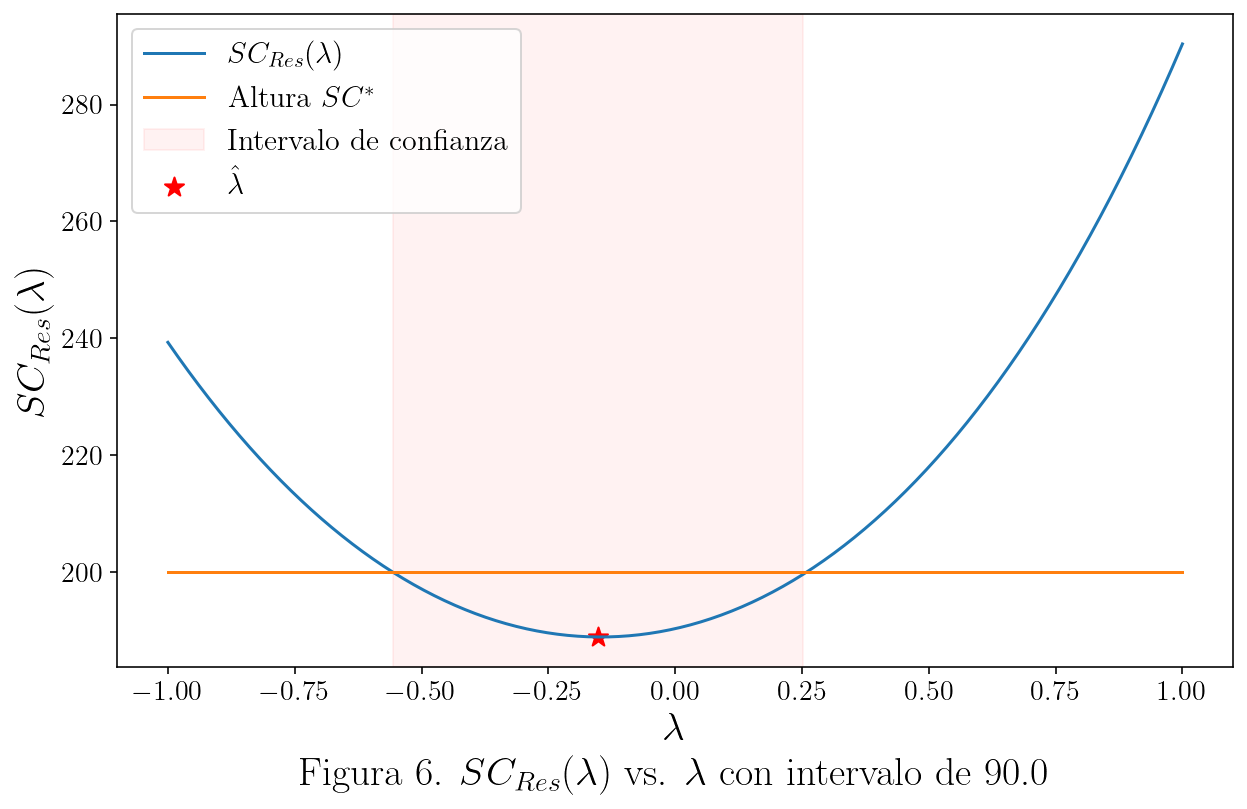

In [17]:
n = len(df.index)
alpha = 0.1
get_CI(lambda_df, n, alpha)

El punto importante a notar en la Figura X es que $\lambda =$  -0.25 se encuentra dentro del intervalo de 90 %  de confianza obtenido para $\hat{\lambda}$.

# e) Grafique $y^{(\lambda)}$ vs. $x$. Comente.

A continuación se transforma la variable respuesta utilizando la transformación de Box-Cox con *lambda*  = -0.25 y se grafican los resultados.

In [18]:
working_columns = ["x", "y", "y_fit"]
df.columns = working_columns
df["y_trans"] = box_cox_transformation(df, "y", -0.25)

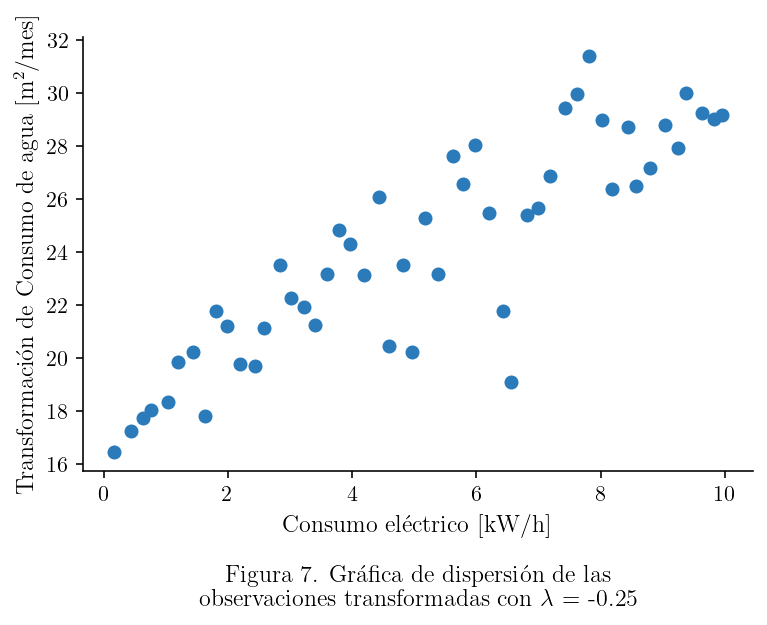

In [19]:
pretty_columns = ["Consumo eléctrico [kW/h]", 
                  "Consumo de agua [m$^2$/mes]", 
                  "Ajuste lineal (respuesta original)",
                  "Transformación de Consumo de agua [m$^2$/mes]"]
df.columns = pretty_columns

params = {
    'X': df['Consumo eléctrico [kW/h]'],
    'y': df['Transformación de Consumo de agua [m$^2$/mes]']
}
plot(
    params = [params],
    num = 7,
    x_labels = ['Consumo eléctrico [kW/h]'],
    y_labels = ['Transformación de Consumo de agua [m$^2$/mes]'],
    captions = ["Gráfica de dispersión de las \n" +  r"observaciones transformadas con $\lambda$ = -0.25"],
    types = ['scatter']
)

En la Figura 7. es claro el desvanecimiento de la tendencia de aumento de la tasa de cambio de las observaciones de la variable respuesta con respecto a las observaciones del regresor. De hecho, los datos transformados demuestran una clara relación lineal.

# f) Ajuste el modelo correspondiente y valídelo. Comente.

En esta sección se obtiene un ajuste de regresión lineal a partir de los datos cuya respuesta fue transformada por medio de la transformación de Box-Cox con *lambda*  = -0.25. El ajuste obtenido, así como los parámetros de éste se encuentran graficados en la Figura 7.

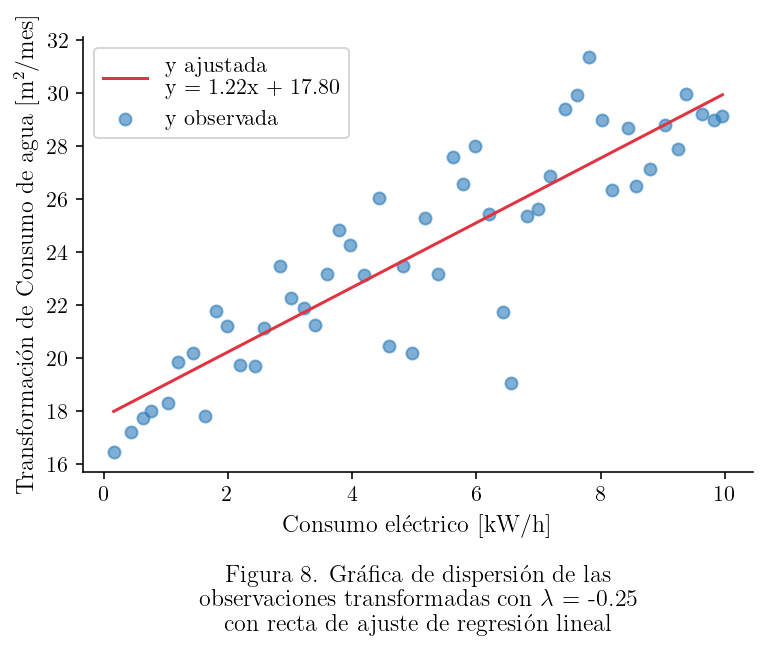

In [20]:
working_columns = ["x", "y", "y_fit", "y_trans"]
df.columns = working_columns

df["y_fit_trans"], beta_0, beta_1 = fit(df, "x", "y_trans")

pretty_columns = ["Consumo eléctrico [kW/h]", 
                  "Consumo de agua [m$^2$/mes]", 
                  "Ajuste lineal (respuesta original)",
                  "Transformación de Consumo de agua [m$^2$/mes]",
                  "Ajuste lineal (respuesta transformada)"]
df.columns = pretty_columns
params = {
    'X': df['Consumo eléctrico [kW/h]'],
    'y': df['Transformación de Consumo de agua [m$^2$/mes]'],
    'b0': beta_0,
    'b1': beta_1
}
plot(
    params = [params],
    num = 8,
    x_labels = ['Consumo eléctrico [kW/h]'],
    y_labels = ['Transformación de Consumo de agua [m$^2$/mes]'],
    captions = ["Gráfica de dispersión de las \n" +  r"observaciones transformadas con $\lambda$ = -0.25" + "\n con recta de ajuste de regresión lineal"],
    types = ['modelo']
)

A continuación se realizan las pruebas de hipótesis necesarias para validar la significancia del ajuste obtenido

In [21]:

working_columns = ["x", "y", "y_fit", "y_trans", "y_fit_trans"]
df.columns = working_columns

_, _, p_value_beta_0 = test_beta_0(df, "x", "y_trans", "y_fit_trans", beta_0)
_, _, p_value_beta_1 = test_beta_1(df, "x", "y_trans", "y_fit_trans", beta_1)
#_, _, p_value_anova = test_analysis_of_variance(df, "y_trans", "y_fit_trans")


Significancia del ajuste: 
	 Como el valor p = 0.00e+00 < 0.05 = 𝛼, se rechaza la hipótesis nula H_0: 𝛽_0 = 0 

Significancia del ajuste: 
	 Como el valor p = 1.11e-16 > 0.05 = 𝛼, se rechaza la hipótesis nula H_0: 𝛽_1 = 0 



Entonces, existe evidencia para afirmar que los datos transformados tienen un comportamiento linea.

También es posible evaluar la calidad del ajuste por medio del coeficiente de determinación $R^2$ que toma un rango de valores entre 0 y 1.

In [22]:
R_2 = get_R_2(df, "y_trans", "y_fit_trans")

El valor de R^2 para este ajuste es 0.7653


Es importante resaltar que aunque el valor de $R^2$ obtenido para el ajuste de los datos trasformados sea mayor que el correspondiente a los datos originales, estas cantidades no son comparables en realidad debido a la transformación aplicada a la variable respuesta.

En la Figura 8. se encuentra la gráfica de los residuales determinados a partir del ajuste obtenido por medio de los datos transformados. Es destacable que la tendencia del error a aumentar conforme el incremento de la respuesta ajustada ha desaparecido y que para este caso los residuales aparentan tener una naturaleza más aleatoria que para el caso de los datos originales.

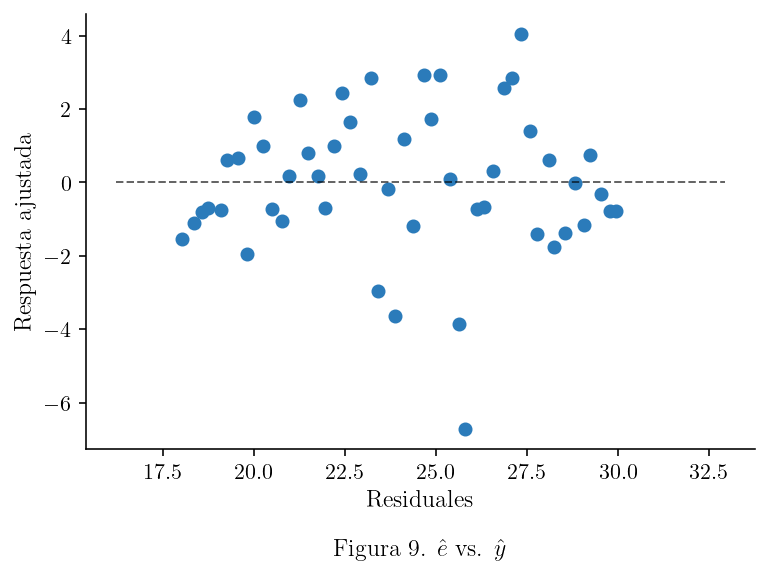

In [23]:
residuales_df = pd.DataFrame(index=df.index, columns=["Respuesta transformada ajustada", "Residuales"])
residuales_df["Respuesta transformada ajustada"] = df["y_fit_trans"]
residuales_df["Residuales"] = df["y_trans"] - df["y_fit_trans"]
params_res = {
    'residuals': residuales_df["Residuales"],
    'y_approx': residuales_df["Respuesta transformada ajustada"],
}

df_qq = df.copy()
df_qq = df_qq.drop(columns = ['y', 'y_fit', 'y_fit_trans'])
df_qq.columns = ['electricidad', 'agua']
fitted, b0, b1, y_approx, residuals, normal_resid = fit_data(df_qq)
params_qq = {
    'residuals': normal_resid
}

plot(
    params = [params_res],
    num = 9,
    x_labels = ['Residuales'],
    y_labels = ['Respuesta ajustada'],
    captions = ['$\hat{e}$ vs. $\hat{y}$'],
    types = ['residual']
)

De la Figura 9. vemos que con este nuevo modelo los residuales presentan un comportamiento más aleatorio que en el primero por lo que es un mejor modelo.

# g) Construya un intervalo del 90% confianza para el consumo **medio** esperado si el consumo de energía eléctrica es de 7.57 kw/hr. (Nota: el intervalo es para el consumo de agua, no la respuesta transformada.).

Se consideran dos aproximaciones para la obtención del intervalo de confianza:
1. Obtenerlo a partir de los parámetros del ajuste obtenido con los datos originales
2. Obtenerlo a partir de los parámetros del ajuste obtenido con los datos transformados y aplicarle la transformación de Box-Cox inversa para obtener un intervalo en las unidades de los datos originales.

In [24]:
alpha = 0.1
x_0 = 7.57

CI_lb, CI_ub = prediction_CI(df, "x", "y", "y_fit", x_0, beta_0_original, beta_1_original, alpha = alpha)

CI_lb = np.round(CI_lb, 2)
CI_ub = np.round(CI_ub, 2)
print("Intervalo obtenido a partir de los parámetros del ajuste original:")
print(f"\tEl valor y_0 ∈ ({CI_lb}, {CI_ub}) con {100*(1-alpha)} % de confianza para x_0 = {x_0}")

Intervalo obtenido a partir de los parámetros del ajuste original:
	El valor y_0 ∈ (11.98, 13.51) con 90.0 % de confianza para x_0 = 7.57


In [25]:
CI_lb, CI_ub = prediction_CI(df, "x", "y_trans", "y_fit_trans", x_0, beta_0, beta_1, alpha = alpha)

CI_lb = np.round(inv_box_cox_transformation_single_obs(df, "y", -0.25, CI_lb), 2)
CI_ub = np.round(inv_box_cox_transformation_single_obs(df, "y", -0.25, CI_ub), 2)
print("Intervalo obtenido a partir de los parámetros del ajuste transformado:")
print(f"\tEl valor y_0 ∈ ({CI_lb}, {CI_ub}) con {100*(1-alpha)} % de confianza para x_bar = {x_0}")

Intervalo obtenido a partir de los parámetros del ajuste transformado:
	El valor y_0 ∈ (11.08, 12.98) con 90.0 % de confianza para x_bar = 7.57


# h) Construya un intervalo de predicción de 95 % para la demanda esperada si la generación de energía es de 5.1 kw/hr.

Nuevamente, se consideran las dos aproximaciones del inciso anterior.

In [26]:
alpha = 0.05
x_0 = 5.1

CI_lb, CI_ub = prediction_CI(df, "x", "y", "y_fit", x_0, beta_0_original, beta_1_original, alpha = alpha, mean = False)

CI_lb = np.round(CI_lb, 2)
CI_ub = np.round(CI_ub, 2)
print("Intervalo obtenido a partir de los parámetros del ajuste original:")
print(f"\tEl valor y_0 ∈ ({CI_lb}, {CI_ub}) con {100*(1-alpha)} % de confianza para x_0 = {x_0}")

Intervalo obtenido a partir de los parámetros del ajuste original:
	El valor y_0 ∈ (4.53, 14.52) con 95.0 % de confianza para x_0 = 5.1


In [27]:
CI_lb, CI_ub = prediction_CI(df, "x", "y_trans", "y_fit_trans", x_0, beta_0, beta_1, alpha = alpha, mean = False)

CI_lb = np.round(inv_box_cox_transformation_single_obs(df, "y", -0.25, CI_lb), 2)
CI_ub = np.round(inv_box_cox_transformation_single_obs(df, "y", -0.25, CI_ub), 2)
print("Intervalo obtenido a partir de los parámetros del ajuste transformado:")
print(f"\nEl valor y_0 ∈ ({CI_lb}, {CI_ub}) con {100*(1-alpha)} % de confianza para x_0 = {x_0}")

Intervalo obtenido a partir de los parámetros del ajuste transformado:

El valor y_0 ∈ (5.33, 13.68) con 95.0 % de confianza para x_0 = 5.1


# Conclusiones

A pesar de que el ajuste de regresión lineal obtenido a partir de los datos originales tuviera una apariencia adecuada, no era un ajuste válido debido a que los datos no satisfacían los supuestos del modelo.

Por medio de la transformación de Box-Cox pudimos obtener un modelo que se ajusta mejor a nuestros datos.